# Variograms

### general background

The variogram or semi-variance is given by:

$
\begin{align}
\gamma(\tau) &= \frac{1}{2} \big \langle [ u(t+\tau) - u(t) ]^2 \big \rangle, \\
&= \big \langle (u-\mu)^2 \big \rangle
- \big \langle [ u(t+\tau) - \mu] [u(t)-\mu] \big \rangle
\end{align}
$

where stationarity was assumed to derive the second equation and the mean of the process $\mu$ was introduced.
For large time lags, the variogram converges to the variable variance.
For an exponentially decaying autocovariance with timescale $T$, the variogram is thus given by:

$
\begin{align}
\gamma(\tau) &= \sigma_0 \Big ( 1 - e^{-t/T} \Big ),
\end{align}
$

where $\sigma_0$ is the variance of the signal.

Under normal assumption: 
$[u(t+\tau) - u(t)]^2 \sim 2\gamma(\tau) \chi_1^2$ 
where $\chi_1^2$ is the chi-squared random variable with 1 degree of freedom.

Fleming et al. 2014 (citing Cressie 1993) argues the variogram offers better estimators than the autocorrelation and this motivates its use.

Estimates of the mean is circumvented
while we may be interested in these.
These need to be estimated independantly.
The variogram helps estimate however the effective degrees of freedom which may be useful to provide confidence intervals for the mean and variance (if a non-parametric method such as bootstrap is not employed).

### Estimations of the variogram

The **Matheron estimator** is the most popular estimator in geostatistics:

$
\begin{align}
\hat \gamma(\tau) = 
\frac{\sum_{t_i-t_j=\tau} |u(t_i) - u(t_j)|^2}{2N(\tau)}
\end{align}
$

where $N(\tau)$ is the number of pairs for lag $\tau$.
This estimate is the average of a variable that has mean $2\gamma(\tau)$ and variance ?? (?? under Gaussian assumption)

`np.correlate` may be used to output a quantity comparable to the Matheron estimator (see `autocorrelation_np.ipynb`).

You will find more estimators in skgstat.estimators. There is the Cressie-Hawkins, which is more robust to extreme values. Other so called robust estimators are Dowd or Genton. 

To account for "data with many large, irregular gaps", Fleming et al. 2014 derive a new weighted variogram estimator that is unbiased (see their appendix):

$
\begin{align}
\hat \gamma(\tau) = 
\frac{\sum_{t_i-t_j=\tau} w_{ij} |u(t_i)-u(t_j)|^2}{2\sum_{t_i-t_j=\tau} w_{ij}}
\end{align}
$

Note that such estimator could be useful for to process raw GDP data.

**Expected distribution of the estimate - confidence intervals ?**

### Fitting variograms to models

Appendix B of Fleming et al. 2014, fitting variograms involve weighted regressions.

The simplest unbiased weighted least squares (WLS) regression involves a number-weighted least squares cost function (Diggle and Ribeiro, 2007):

$
\begin{align}
L_N(\theta | \hat \gamma) = \sum_{\tau>0} n(\tau) | \gamma(\tau|\theta) - \hat \gamma (\tau) |^2
\end{align}
$

The most commonly used WLS is given by (model) variogram weighting (Cressie, 1993):

$
\begin{align}
L_V (\theta | \hat \gamma) = 
\sum_{\tau>0} \frac{| \gamma(\tau|\theta) - \hat \gamma (\tau) |^2}{\gamma(\tau|\theta)^2 /n(\tau)}
\end{align}
$

Fleming et al. 2014 argues for a log-based cost function.

### Comparing different variogram models

- visual inspection
- RMSE
- AIC


SciKitGStat: "This is quite important. We find all 6 models to describe the experimental variogram more or less equally well in terms of RMSE. Think of the implications: We basically can use any model we like. This is a problem as i.e. the gaussian and the spherical model describe fundamentally different spatial properties. Thus, our model selection should be driven by interpretation of the variogram, and not the difference in RMSE of only 0.4%, which might very likely not be significant at all."

Fleming et al. 2014: "however, given the correlated nature of the variogram errors, AIC should not be used to select between qualitatively similar SVF models"



### Parameter uncertainties

Fleming is able to find some: bootstrap or statistical expectation?


### references:
- [Fleming et al. 2014](https://www.google.com/search?q=10.1111%2F2041-210X.12176): From Fine-Scale Foraging to Home Ranges: A Semivariance Approach to Identifying Movement Modes across Spatiotemporal Scales

### illustration

Generate a 100 day time series with a 10 days decorrelation timescale

In [1]:
import xarray as xr
import numpy as np

from scipy.optimize import minimize
from scipy import stats                                                         
#from numpy.linalg import inv, slogdet
#from scipy.stats import chi2

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

import skgstat as skg
from pprint import pprint

import sstats.tseries as ts
import sstats.sigp as sigp

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
#ts.exp_autocorr?

In [3]:
mu=0 # true mean
sigma0 = 1 # true variance
T = 10 # days, decorrelation timescale

delta_T = 100 # time series length
#delta_T = 300 # time series length
dt = 3/24 # sampling interval in days
Nw0 = 10 # number of windows averaged in the nominal case
Nw = [2, 5, 10, 20, 40]


sigma_true = lambda tau: sigma0*np.exp(-abs(tau)/T)
gamma_true = lambda tau: sigma0*(1-np.exp(-abs(tau)/T))

In [4]:
u = mu + ts.exp_autocorr((delta_T, dt), T, 
                         np.sqrt(sigma0), 
                         #burnin=int(10*T/dt),
                         draws=1000, 
                         seed=0,
                        ).compute()

## derived parameters:

# total number of points
N = u.time.size # = delta_T/dt 

# AR parameter used in approximated formulas
#a = np.exp(-dt/T)

In [5]:
ds = sigp.svariance(u, "time").rename("gamma_hat").to_dataset()
ds["gamma"] = ("lags", gamma_true(ds.lags.values))

In [6]:
def plot_mean(ds, title="semi-variance"):
    fig, ax = plt.subplots(1,1)

    ds["gamma_hat"].mean("draw").plot(label="mean")

    ds["gamma_hat"].quantile(0.05, "draw").plot(color="0.5", label="5%, 95%")
    ds["gamma_hat"].quantile(0.95, "draw").plot(color="0.5")

    ds["gamma"].plot(color="k", label="true")

    ax.legend()
    ax.grid()
    ax.set_title(title)

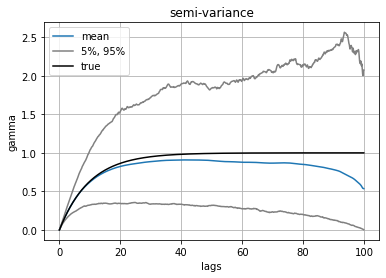

In [7]:
plot_mean(ds)

In [8]:
# averageds Nw0 (=10) independent autocorrelations together 
dsw = ds.coarsen(draw=Nw0).mean()

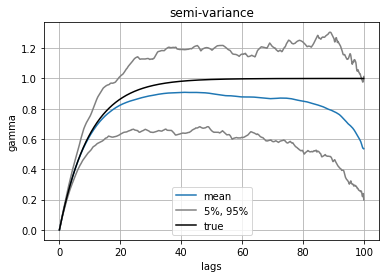

In [9]:
plot_mean(dsw)

### distribution

Difficult for now, is this related to the autocorrelation of the data? 
(Schabenberg p 153)

In [10]:
def show_dist(pdf, ax, 
              *args, 
              label="theoretical pdf", color="k", 
              **kwargs):
    #stats.norm.pdf, loc=mu, scale=sigma0/np.sqrt(Neff)
    x0, x1 = ax.get_xlim()  # extract the endpoints for the x-axis
    x_pdf = np.linspace(x0, x1, 100)
    y_pdf = pdf(x_pdf, *args, **kwargs)
    ax.plot(x_pdf, y_pdf, color=color, lw=2, label=label)

/Users/aponte/.miniconda3/envs/stats/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


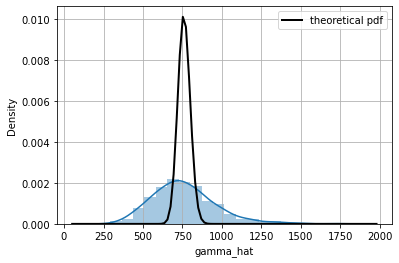

In [11]:
_lag = 5
_df = N - int(_lag/dt)
_ds = ds.sel(lags=_lag)
_gamma = float(_ds.gamma)

ax = sns.distplot(_ds.gamma_hat/_gamma*_df, bins=20, norm_hist=True)
show_dist(stats.chi2.pdf, ax,
          _df, #scale=, #float(_ds.gamma)
          label="theoretical pdf", color="k", 
         )
ax.grid()
ax.legend()

In [12]:
#stats.chi2?

### model fit

In [13]:
def fit_model(ds, model, params, 
              method="n-weighted", 
              lag_max=None, 
              nugget=False,
             ):
    """ Fit a semi-variance model to semi-variance estimates
    """

    variables = ["gamma_hat", "lags"]
    dim = "lags"

    if method=="n-weighted":
        weights = np.arange(N,0,-1)/N
        
    if lag_max is not None:
        ds = ds.sel(lags=slice(0, lag_max))
        weights = weights[:ds.lags.size]
        
    if nugget:
        ds = ds.isel(lags=slice(1, None))
        weights = weights[1:]
        
    def J(x, gamma_hat, lags):
        return np.mean( (gamma_hat - model(lags, *x) )**2 * weights )

    dsm = sigp.minimize_xr(J, ds, params, variables, dim)
    
    # converts parameters (in x) into proper variables
    for v in params:
        dsm[v] = dsm.x.sel(parameters=v)
    dsm = dsm.drop("x")
    dsm.attrs["method"] = method

    gamma_fit = model(ds.lags, *[dsm[v] for v in params])
    
    return dsm, gamma_fit

In [14]:
params=dict(sigma0=10, T=1)
model = lambda tau, sigma0, T: sigma0*(1-np.exp(-abs(tau)/T))

dsm, ds["gamma_fit"] = fit_model(ds, model, params)

# with coarsened data
dsm_w, dsw["gamma_fit"] = fit_model(dsw, model, params)

In [15]:
def plot_svariance(truth, labels, *args, offset=0):

    fig, ax = plt.subplots(1,1)

    truth.plot(color="k", label="true")

    for i, ds in enumerate(args):
        ds.gamma_hat.plot(label="gamma_hat, "+labels[i], color=f"C{i+offset}")
        ds.gamma_fit.plot(label="fit, "+labels[i], color=f"C{i+offset}", ls="--")

    ax.grid()
    ax.legend()
    
    return fig, ax

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:title={'center':'draw = 4.5'}, xlabel='lags', ylabel='gamma_fit'>)

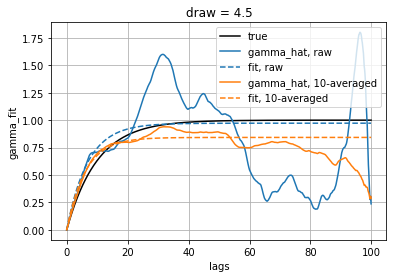

In [16]:
plot_svariance(ds.gamma, ["raw", f"{Nw0}-averaged"], 
               ds.isel(draw=0), dsw.isel(draw=0))

In [17]:
def plot_param(ds, param, truth, bins=None, ax=None, color=None):

    if ax is None:
        fig, ax = plt.subplots(1,1)

    ax.axvline(truth, color="k") # outliers !!

    ds[param].plot.hist(bins=bins, color=color, density=True, alpha=0.7)
    
    median = ds[param].median() # outliers !!
    ax.axvline(median, lw=3, color=color) 
    ax.axvline(median, ls="--", color="w")

    return ax

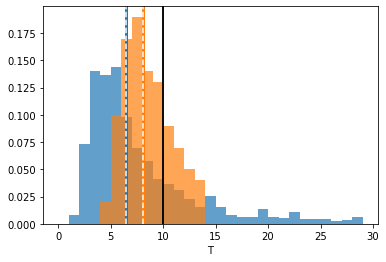

In [18]:
bins = np.arange(0,30)
ax = plot_param(dsm, "T", T, bins=bins, color="C0")
plot_param(dsm_w, "T", T, bins=bins, color="C1", ax=ax);

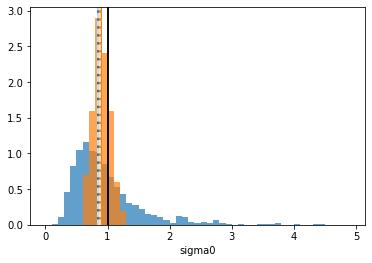

In [19]:
bins=np.arange(0,5,.1)
ax = plot_param(dsm, "sigma0", sigma0, bins=bins, color="C0")
plot_param(dsm_w, "sigma0", sigma0, bins=bins, color="C1", ax=ax);

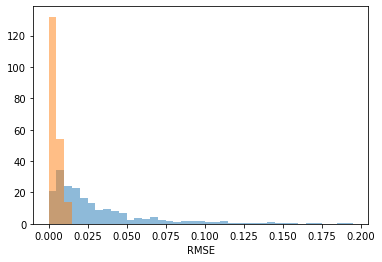

In [20]:
bins=np.arange(0,0.2,.005)
dsm["fun"].rename("RMSE").plot.hist(bins=bins, density=True, alpha=0.7)
dsm_w["fun"].rename("RMSE").plot.hist(bins=bins, density=True, alpha=0.7);

### more extensive inspection of sensitivity to averaging

bias, variance, percentiles of parameters

There seem to be low biases for the temporal timescale and variance: sensitivity to time window length?

This bias do indeed decrease if the width of the time window is increased (`delta_T`). \
300 days induced biases smaller than 5% approximately for example.

**Would bootstrapping allow to recover adequate confidence intervals**

In [21]:
def process_average(ds, Nw, model, params, alpha=0.05):
    """ coarsen data and compute estimator statistics
    """

    ds = ds.coarsen(draw=Nw).mean()
    
    dsm, _ = fit_model(ds, model, params)
    
    # mean
    mean = xr.merge([dsm[p].mean().rename(p+"_mean") for p in params])
    # median
    median = xr.merge([dsm[p].median().rename(p+"_median") for p in params])
    # variance
    var = xr.merge([dsm[p].var().rename(p+"_var") for p in params])
    # quantiles
    quantiles = xr.merge([dsm[p].quantile([alpha, 1-alpha]).rename(p+"_q") for p in params])    
    
    ds_out = xr.merge([mean, median, var, quantiles])
        
    return ds_out

In [22]:
ds_Nw = xr.concat([process_average(ds, n, model, params) for n in Nw], 
                  dim=xr.DataArray(_Nw, name="Nw", dims="Nw"))

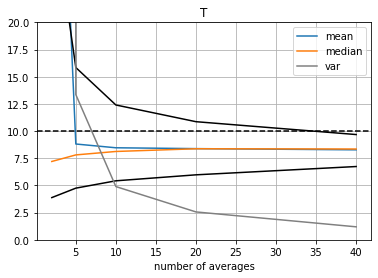

In [23]:
p = "T"
truth = T

fig, ax = plt.subplots(1,1)
ds_Nw[p+"_mean"].plot(label="mean")
ds_Nw[p+"_median"].plot(label="median")
ds_Nw[p+"_q"].plot.line(x="Nw", color="k", add_legend=False)
ds_Nw[p+"_var"].plot(color="0.5", label="var")

ax.axhline(T, color="k", ls="--")
ax.grid()
ax.set_ylim(0,2*truth)
ax.set_title(p)
ax.set_xlabel("number of averages")
ax.set_ylabel("")
ax.legend()

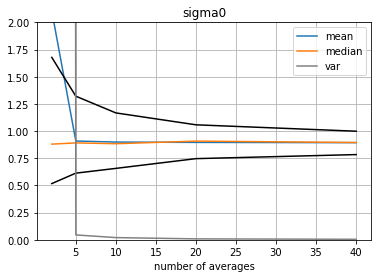

In [24]:
p = "sigma0"
truth = sigma0

fig, ax = plt.subplots(1,1)
ds_Nw[p+"_mean"].plot(label="mean")
ds_Nw[p+"_median"].plot(label="median")
ds_Nw[p+"_q"].plot.line(x="Nw", color="k", add_legend=False)
ds_Nw[p+"_var"].plot(color="0.5", label="var")

ax.axhline(T, color="k", ls="--")
ax.grid()
ax.set_ylim(0,2*truth)
ax.set_title(p)
ax.set_xlabel("number of averages")
ax.set_ylabel("")
ax.legend()

### compare with gaussian fit

In [25]:
params=dict(sigma0=10, T=1)
model_gaussian = lambda tau, sigma0, T: sigma0*(1-np.exp(-abs(tau/T)**2))

dsm_gaussian, gamma_gaussian = fit_model(dsw, model_gaussian, params)

Visual comparison

(0.0, 40.0)

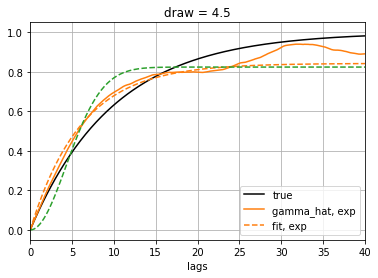

In [26]:
i = 0
fig, ax = plot_svariance(ds.gamma, ["exp"], 
               dsw.isel(draw=i), offset=1)

gamma_gaussian.isel(draw=i).plot(label="fit, gaussian", color="C2", ls="--")

ax.set_xlim(0,T*4)

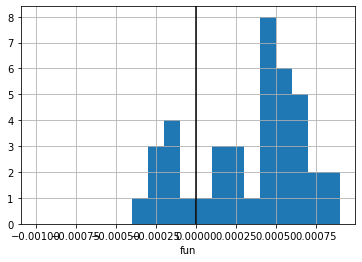

In [27]:
fig, ax = plt.subplots(1,1)

dRMSE = dsm_gaussian.fun - dsm_w.fun
delta = 1e-3
dRMSE.plot.hist(bins=np.arange(-delta,delta,delta/10));

ax.axvline(0, color="k")

ax.grid()

In [28]:
def get_success(delta):
    """ count fraction of time delta is positive
    """
    count = float(xr.where(delta>0, 1, 0).sum("draw"))
    return count/delta.draw.size

success = get_success(dRMSE)
print(f"Success probability is {success*1e2:.1f}%")

Success probability is 90.0%


#### Loop over different number of averages

In [29]:
def process_average_model(ds, Nw, models, alpha=0.05):
    """ coarsen data and compute estimator statistics
    """

    ds = ds.coarsen(draw=Nw).mean()
    
    labels=list(models)
    
    dsm = {}
    for label, m in models.items():
        _dsm, _ = fit_model(ds, m["gamma"], m["params"])
        dsm[label] = _dsm

    # compare models RMSE with first one: rmse
    ds_out = xr.concat([(_dsm.fun - dsm[labels[0]].fun).rename("delta_rmse")
                        for label, _dsm in dsm.items()
                       ],
                       dim=xr.DataArray(labels, name="model", dims="model"),
                      )
    return ds_out

In [30]:
#
models = dict(exp=dict(gamma=model, params=params),
              gaussian=dict(gamma=model_gaussian, params=params),
             )

In [31]:
d_md = {n: process_average_model(ds, n, models) for n in Nw}

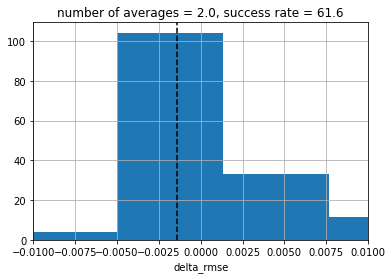

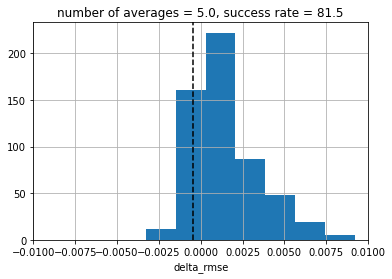

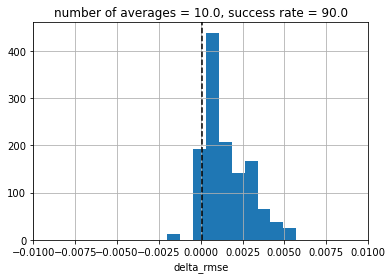

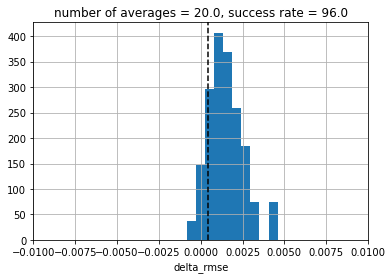

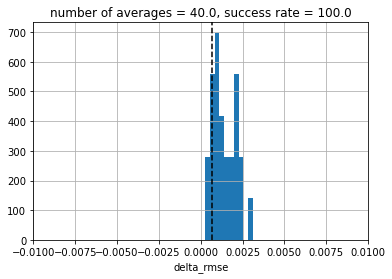

In [32]:
alpha = 0.9

for n, _d in d_md.items():
    
    fig, ax = plt.subplots(1,1)
    
    _da = _d.sel(model="gaussian")
    _da.plot.hist(density=True, label="{}".format(float(n)) )  #alpha=0.5,)
    _qt = _da.quantile([1-alpha])
    ax.axvline(float(_qt), ls="--", color="k")
    
    #ax.legend()
    ax.grid()
    ax.set_xlim(-1e-2,1e-2)
    
    success = get_success(_da)
    
    ax.set_title(f"number of averages = {float(n)}, success rate = {success*1e2:.1f}")

The success rate is also a function of the length of the time window (`delta_T`).
For only 2 averages, the success rate with 300 days window is about 85% for example against 62% for 100 days.

----

## compare with MLE

bias, variance, error in parameters estimation